# Programming Assignment 4: Clustering Analysis


## Imports and Settings


In [1]:
import os
import ssl
import warnings
import xml.etree.ElementTree as ET
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from sklearn.cluster import (
    DBSCAN,
    AgglomerativeClustering,
    BisectingKMeans,
    KMeans,
    SpectralClustering,
)
from sklearn.decomposition import PCA
from sklearn.metrics import fowlkes_mallows_score, silhouette_score
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader

warnings.filterwarnings("ignore")
ssl._create_default_https_context = ssl._create_unverified_context

## Define Constants and Directories


In [2]:
base_image_directory = "./Dataset/Images"
base_annotation_directory = "./Dataset/Annotation"
grayscale_output_directory = "./Ass4/Grayscale_Images"
edge_histograms_output_directory = "./Ass4/EdgeHistograms"
cropped_images_output_directory = "./Ass4/Cropped"

crop_size = 224
dog_class_labels = [
    "n02087394-Rhodesian_ridgeback",
    "n02093256-Staffordshire_bullterrier",
    "n02097209-standard_schnauzer",
    "n02102318-cocker_spaniel",
]

Path(grayscale_output_directory).mkdir(parents=True, exist_ok=True)
Path(edge_histograms_output_directory).mkdir(parents=True, exist_ok=True)
Path(cropped_images_output_directory).mkdir(parents=True, exist_ok=True)

## Define Helper Functions


In [3]:
def extract_bounding_boxes(annotation_file):
    tree = ET.parse(annotation_file)
    root = tree.getroot()
    objects = root.findall("object")
    bounding_boxes = []
    for obj in objects:
        bbox = obj.find("bndbox")
        xmin = int(bbox.find("xmin").text)
        ymin = int(bbox.find("ymin").text)
        xmax = int(bbox.find("xmax").text)
        ymax = int(bbox.find("ymax").text)
        bounding_boxes.append((xmin, ymin, xmax, ymax))
    return bounding_boxes


def crop_and_resize_image(image_path, annotation_path, output_directory):
    image = Image.open(image_path)
    bounding_boxes = extract_bounding_boxes(annotation_path)
    cropped_images = []
    for bbox in bounding_boxes:
        cropped = image.crop(bbox)
        resized = cropped.resize((crop_size, crop_size), Image.Resampling.LANCZOS)
        image_name = os.path.basename(image_path)
        save_path = os.path.join(output_directory, image_name)
        resized.convert("RGB").save(save_path)
        cropped_images.append(cropped)
    return image, cropped_images


def load_images(cropped_dir, classes):
    image_paths = []
    labels = []
    transformation = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
    for idx, dog_class in enumerate(classes):
        class_dir = os.path.join(cropped_dir, dog_class)
        if os.path.exists(class_dir):
            for img_file in os.listdir(class_dir):
                if img_file.endswith(".jpg"):
                    image_paths.append(os.path.join(class_dir, img_file))
                    labels.append(idx)
    return image_paths, labels, transformation


def extract_features(model, data_loader, device):
    feature_list = []
    label_list = []
    model.eval()
    with torch.no_grad():
        for images, batch_labels in data_loader:
            images = images.to(device)
            feature_maps = model(images)
            features = torch.mean(feature_maps, dim=[2, 3]).cpu().numpy()
            feature_list.extend(features)
            label_list.extend(batch_labels.numpy())
    return np.array(feature_list), np.array(label_list)


def compute_edge_histogram(image, bins=36):
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    magnitude = np.sqrt(sobelx**2 + sobely**2)
    angle = np.arctan2(sobely, sobelx) * 180 / np.pi
    histogram = np.zeros(bins)
    for i in range(magnitude.shape[0]):
        for j in range(magnitude.shape[1]):
            if magnitude[i, j] > 30:
                bin_index = int((angle[i, j] + 180) * bins / 360)
                if bin_index == bins:
                    bin_index = 0
                histogram[bin_index] += magnitude[i, j]
    if np.sum(histogram) > 0:
        histogram /= np.sum(histogram)
    return histogram


def process_images_and_pca(cropped_dir, classes):
    histograms = []
    labels = []
    for class_idx, dog_class in enumerate(classes):
        class_dir = os.path.join(cropped_dir, dog_class)
        if os.path.exists(class_dir):
            for img_file in os.listdir(class_dir):
                if img_file.endswith(".jpg"):
                    img_path = os.path.join(class_dir, img_file)
                    img = cv2.imread(img_path)
                    hist = compute_edge_histogram(img)
                    histograms.append(hist)
                    labels.append(class_idx)
    X = np.array(histograms)
    y = np.array(labels)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    return X_pca, y, pca.explained_variance_ratio_


def plot_pca(X, y, classes, title):
    plt.figure(figsize=(10, 8))
    colors = ["r", "g", "b", "y"]
    for i in range(len(classes)):
        mask = y == i
        plt.scatter(
            X[mask, 0],
            X[mask, 1],
            c=colors[i],
            label=classes[i].split("-")[1],
            alpha=0.6,
        )
    plt.xlabel("First Principal Component")
    plt.ylabel("Second Principal Component")
    plt.title(title)
    plt.legend()
    plt.show()


def plot_clustering_results(X, cluster_labels, title):
    plt.figure(figsize=(10, 8))
    unique_labels = np.unique(cluster_labels)
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))
    for label, color in zip(unique_labels, colors):
        mask = cluster_labels == label
        label_name = "Noise" if label == -1 else f"Cluster {label}"
        plt.scatter(X[mask, 0], X[mask, 1], c=[color], label=label_name)
    plt.title(title)
    plt.xlabel("First Principal Component")
    plt.ylabel("Second Principal Component")
    plt.legend()
    plt.show()


def evaluate_clustering(method_name, predicted_labels, data, true_labels):
    if -1 in predicted_labels:
        mask = predicted_labels != -1
        fm = fowlkes_mallows_score(true_labels[mask], predicted_labels[mask])
        silhouette = silhouette_score(data[mask], predicted_labels[mask])
    else:
        fm = fowlkes_mallows_score(true_labels, predicted_labels)
        silhouette = silhouette_score(data, predicted_labels)
    return fm, silhouette

## Image Processing and Feature Extraction


In [4]:
original_images = {}
cropped_images = {}
total_cropped = 0

for dog_class in dog_class_labels:
    image_dir = os.path.join(base_image_directory, dog_class)
    annotation_dir = os.path.join(base_annotation_directory, dog_class)
    output_dir = os.path.join(cropped_images_output_directory, dog_class)
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    for img_file in os.listdir(image_dir):
        if img_file.endswith(".jpg"):
            image_path = os.path.join(image_dir, img_file)
            annotation_file = os.path.join(annotation_dir, img_file.replace(".jpg", ""))
            if os.path.exists(annotation_file):
                orig_img, cropped = crop_and_resize_image(
                    image_path, annotation_file, output_dir
                )
                original_images[img_file] = orig_img
                cropped_images[img_file] = cropped
                total_cropped += len(cropped)
            else:
                print(f"Annotation missing for {img_file}, skipping.")

print(f"Total cropped images: {total_cropped}")

Total cropped images: 697


## ResNet Feature Extraction


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_model = models.resnet18(pretrained=True)
resnet_model = torch.nn.Sequential(*(list(resnet_model.children())[:-2]))
resnet_model = resnet_model.to(device)

image_paths, image_labels, transform_pipeline = load_images(
    cropped_images_output_directory, dog_class_labels
)
dataset = [
    (
        transforms.ToPILImage()(transforms.ToTensor()(Image.open(path).convert("RGB"))),
        label,
    )
    for path, label in zip(image_paths, image_labels)
]
tensor_images = torch.stack(
    [transform_pipeline(Image.open(path).convert("RGB")) for path in image_paths]
)
tensor_labels = torch.tensor(image_labels)
data_loader = DataLoader(
    list(zip(tensor_images, tensor_labels)), batch_size=32, shuffle=False
)

print("Extracting ResNet features...")
resnet_features, resnet_labels = extract_features(resnet_model, data_loader, device)

Extracting ResNet features...


## Edge Histogram and PCA


Computing edge histograms and performing PCA...
Explained variance ratio: [0.49122624 0.13395676]


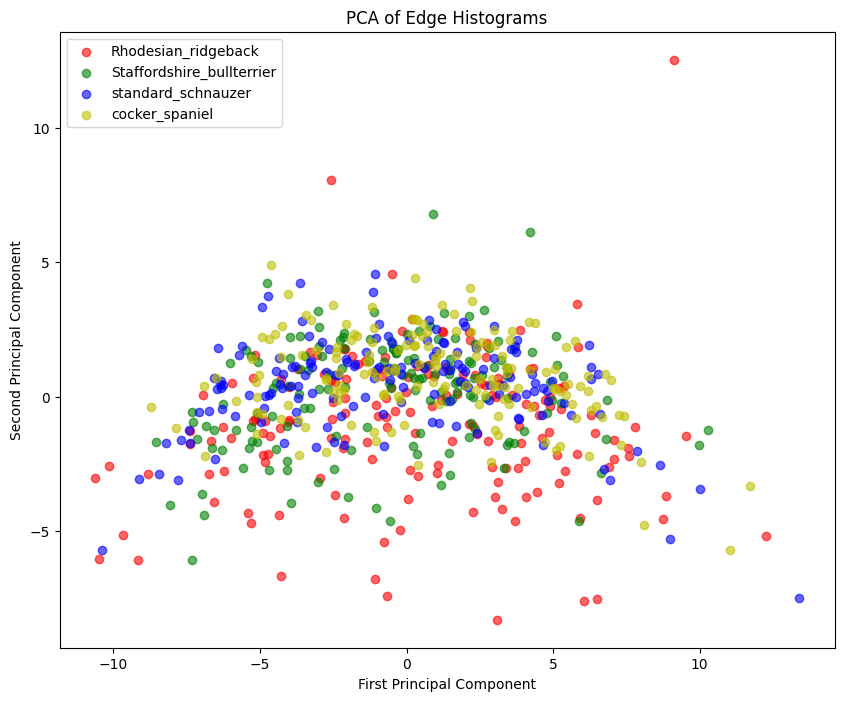

In [6]:
print("Computing edge histograms and performing PCA...")
edge_pca_features, edge_true_labels, explained_variance = process_images_and_pca(
    cropped_images_output_directory, dog_class_labels
)
print("Explained variance ratio:", explained_variance)
plot_pca(
    edge_pca_features, edge_true_labels, dog_class_labels, "PCA of Edge Histograms"
)

## Clustering Algorithms


In [7]:
def perform_kmeans(X, init_method, random_state=42):
    kmeans = KMeans(
        n_clusters=4, init=init_method, n_init=10, random_state=random_state
    )
    labels = kmeans.fit_predict(X)
    return labels


def perform_bisecting_kmeans(X, init_method, random_state=42):
    bisect_kmeans = BisectingKMeans(
        n_clusters=4, init=init_method, random_state=random_state
    )
    labels = bisect_kmeans.fit_predict(X)
    return labels


def perform_spectral_clustering(X, random_state=42):
    spectral = SpectralClustering(n_clusters=4, random_state=random_state)
    labels = spectral.fit_predict(X)
    return labels


def perform_dbscan(X, eps, min_samples):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X)
    return labels


def perform_agglomerative_clustering(X, linkage):
    agglom = AgglomerativeClustering(n_clusters=4, linkage=linkage)
    labels = agglom.fit_predict(X)
    return labels


cluster_methods = {}

cluster_methods["K-means (Random Init)"] = perform_kmeans(
    edge_pca_features, init_method="random"
)
cluster_methods["K-means++"] = perform_kmeans(
    edge_pca_features, init_method="k-means++"
)
cluster_methods["Bisecting K-means"] = perform_bisecting_kmeans(
    edge_pca_features, init_method="random"
)
cluster_methods["Spectral Clustering"] = perform_spectral_clustering(edge_pca_features)

# DBSCAN parameter selection
best_eps = 0
best_min_samples = 0
best_silhouette = -1
best_dbscan_labels = None

for eps in np.arange(0.1, 2.0, 0.1):
    for min_samples in range(2, 10):
        db_labels = perform_dbscan(edge_pca_features, eps, min_samples)
        unique_clusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)
        if unique_clusters == 4:
            mask = db_labels != -1
            if np.sum(mask) > 1:
                score = silhouette_score(edge_pca_features[mask], db_labels[mask])
                if score > best_silhouette:
                    best_silhouette = score
                    best_eps = eps
                    best_min_samples = min_samples
                    best_dbscan_labels = db_labels

if best_dbscan_labels is not None:
    cluster_methods["DBSCAN"] = best_dbscan_labels
    print(f"Best DBSCAN parameters: eps={best_eps}, min_samples={best_min_samples}")
else:
    print("No suitable DBSCAN parameters found for 4 clusters.")

linkage_methods = ["ward", "complete", "average", "single"]
for linkage in linkage_methods:
    agglom_labels = perform_agglomerative_clustering(edge_pca_features, linkage)
    cluster_methods[f"Agglomerative ({linkage})"] = agglom_labels

Best DBSCAN parameters: eps=0.2, min_samples=6


## Plot Clustering Results


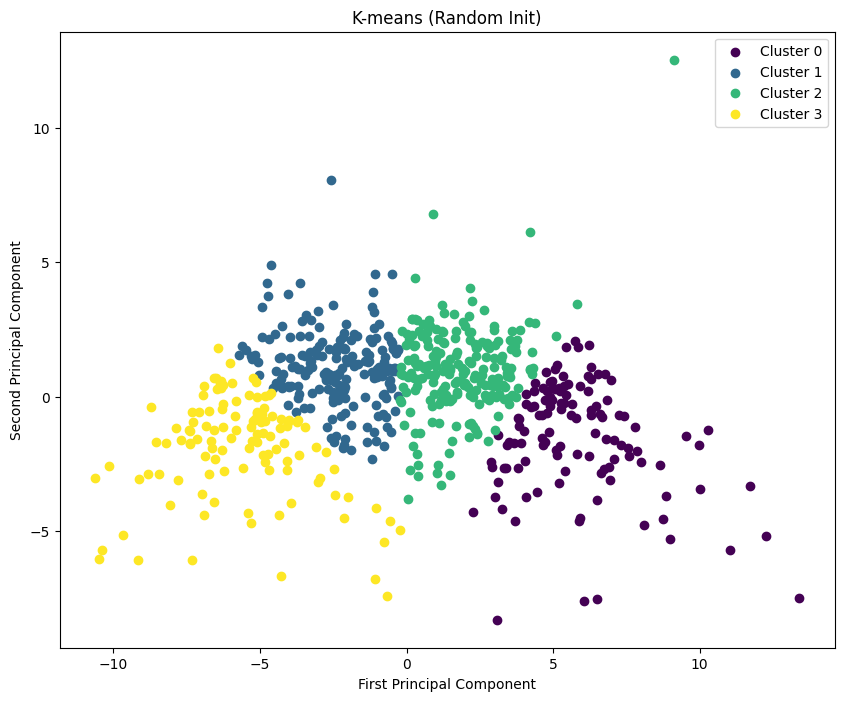

K-means (Random Init) Silhouette Score: 0.3477


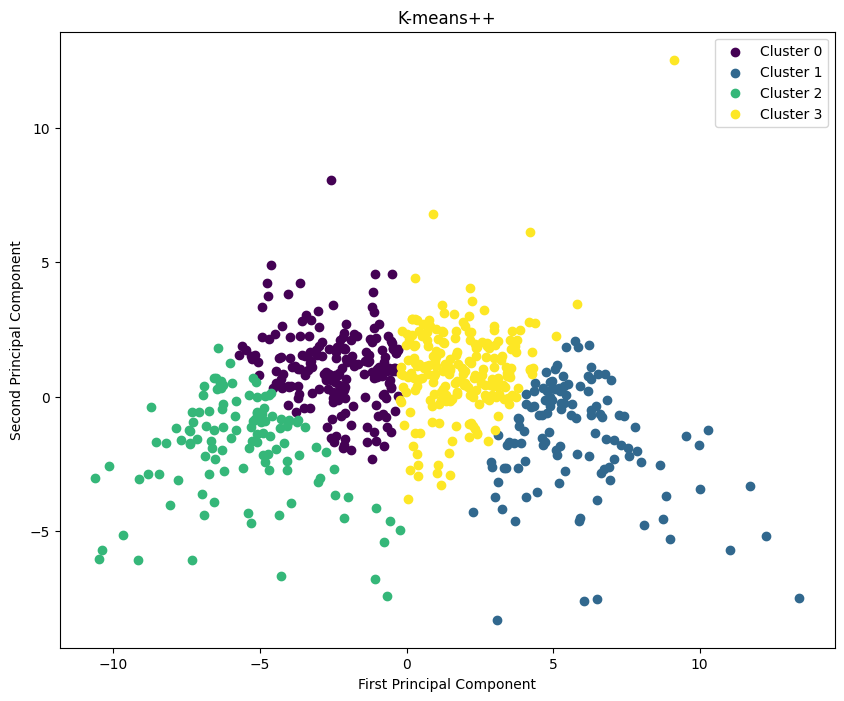

K-means++ Silhouette Score: 0.3477


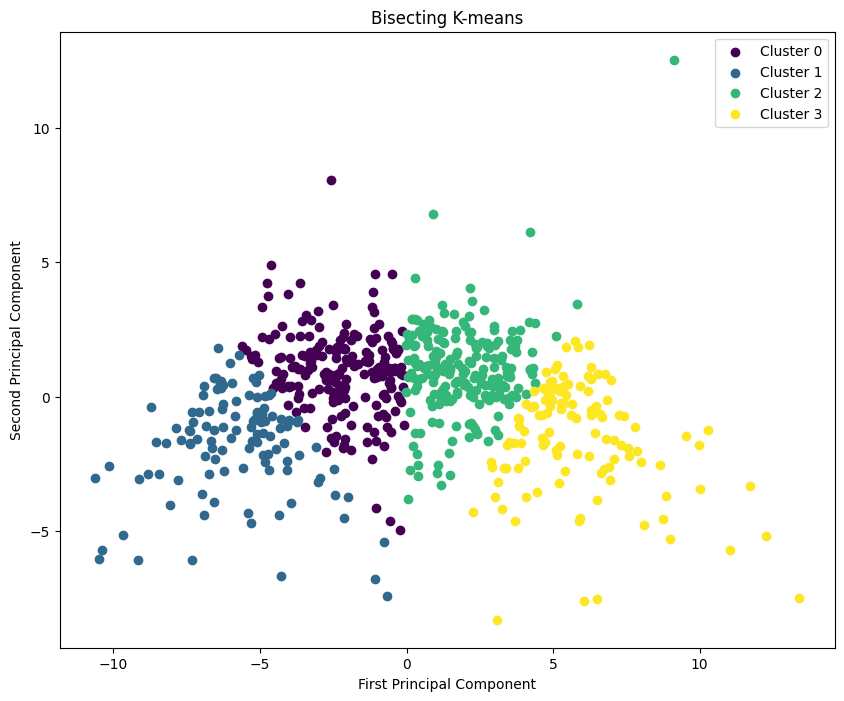

Bisecting K-means Silhouette Score: 0.3470


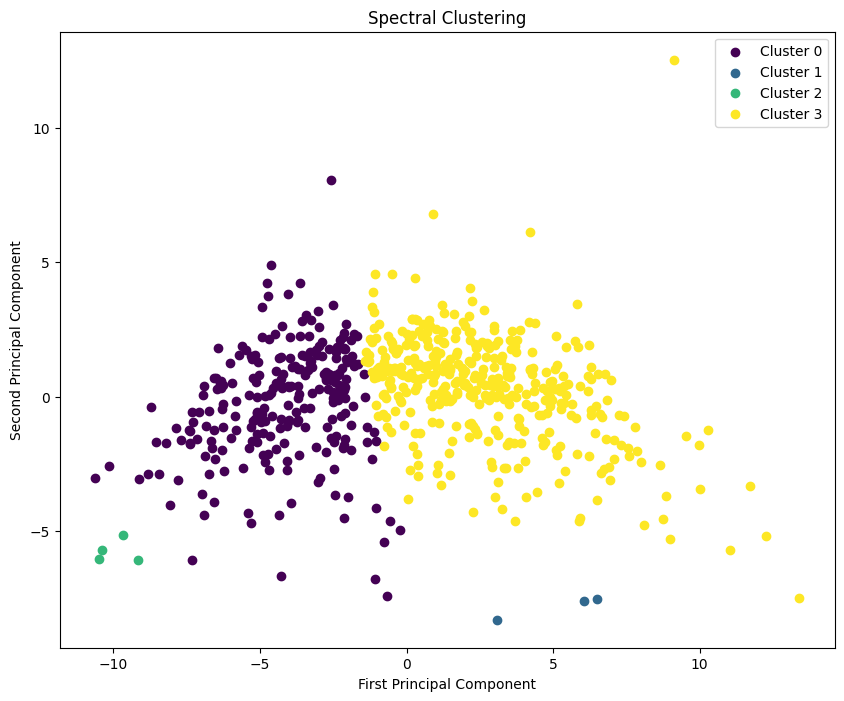

Spectral Clustering Silhouette Score: 0.3680


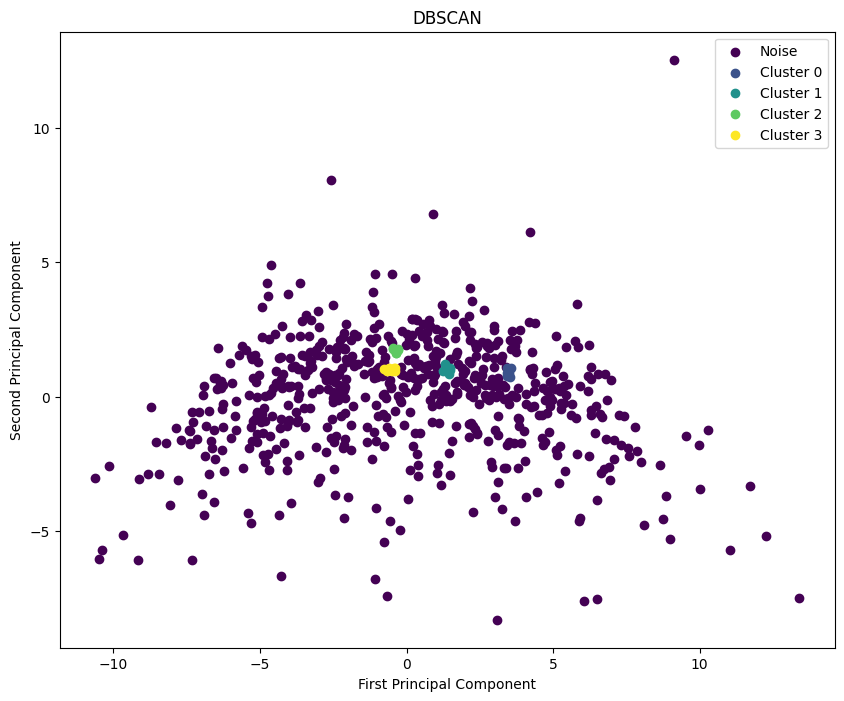

DBSCAN Silhouette Score: 0.8347


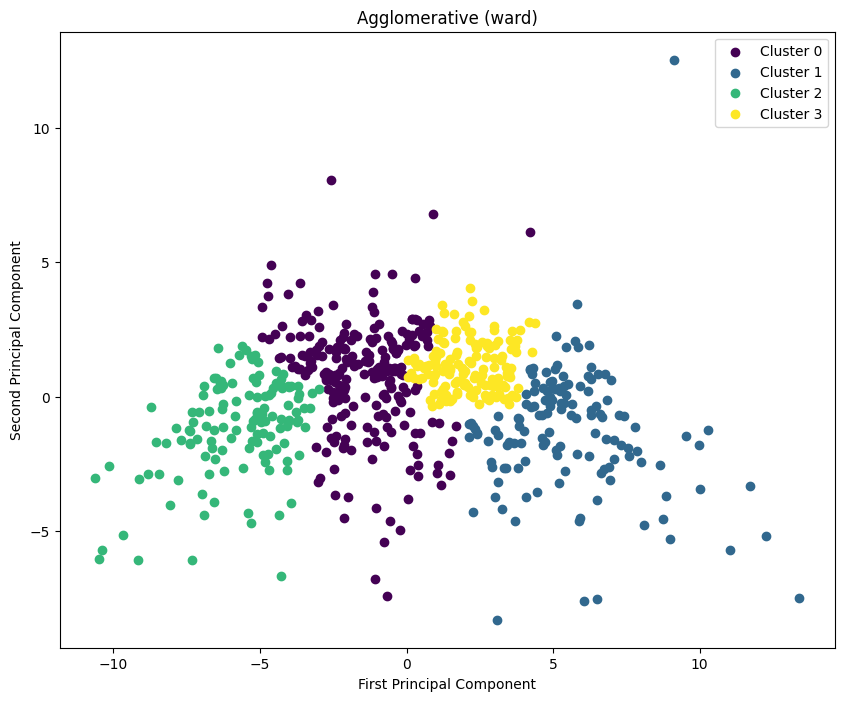

Agglomerative (ward) Silhouette Score: 0.2982


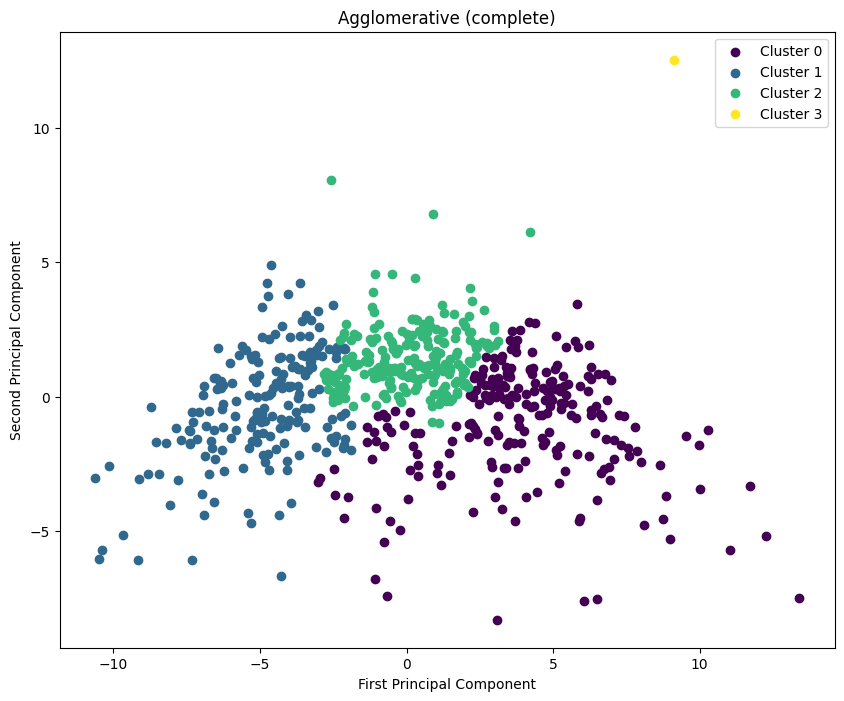

Agglomerative (complete) Silhouette Score: 0.3274


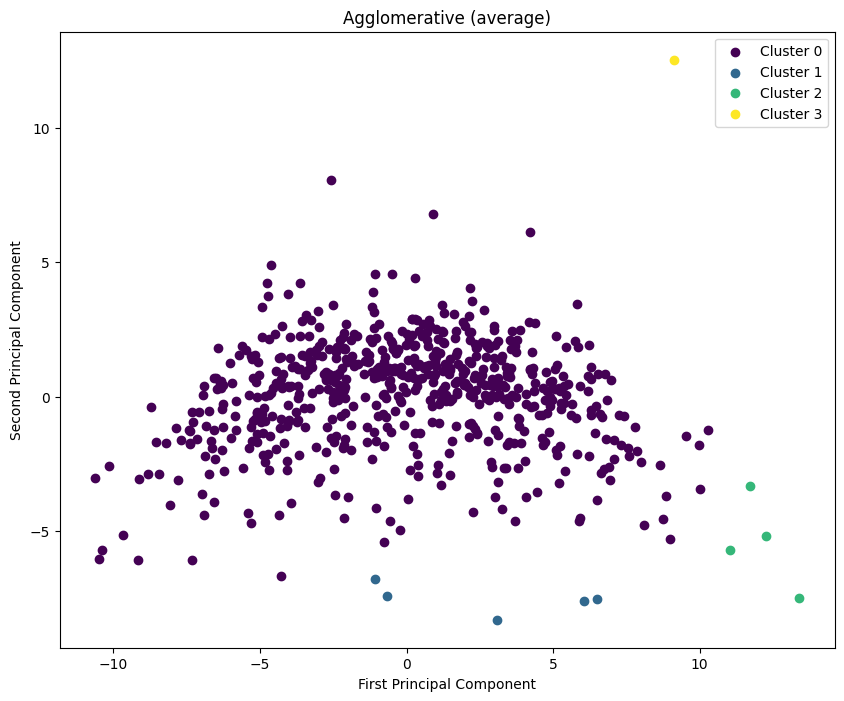

Agglomerative (average) Silhouette Score: 0.3865


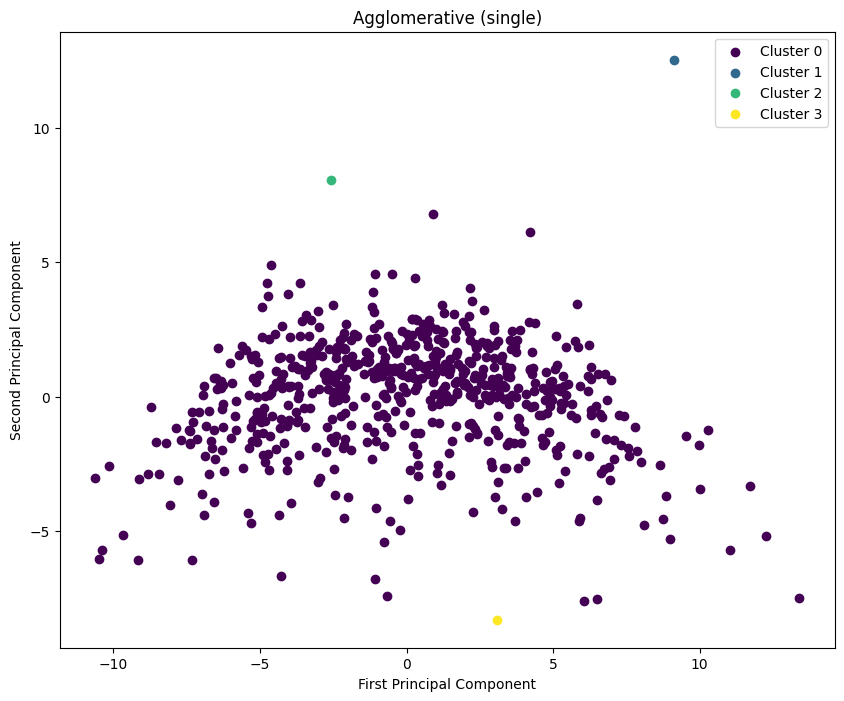

Agglomerative (single) Silhouette Score: 0.2662


In [8]:
for method, labels in cluster_methods.items():
    plot_clustering_results(edge_pca_features, labels, method)
    silhouette = (
        silhouette_score(edge_pca_features, labels)
        if -1 not in labels
        else silhouette_score(edge_pca_features[labels != -1], labels[labels != -1])
    )
    print(f"{method} Silhouette Score: {silhouette:.4f}")

## Clustering Evaluation


In [9]:
evaluation_results = {}

for method, labels in cluster_methods.items():
    fm, silhouette = evaluate_clustering(
        method, labels, edge_pca_features, edge_true_labels
    )
    evaluation_results[method] = (fm, silhouette)

print("\nDetailed Evaluation Results:")
print("-" * 80)
print(f"{'Method':<25} {'Fowlkes-Mallows':<20} {'Silhouette':<20}")
print("-" * 80)
for method, (fm, silhouette) in evaluation_results.items():
    print(f"{method:<25} {fm:<20.4f} {silhouette:<20.4f}")

fm_ranking = sorted(evaluation_results.items(), key=lambda x: x[1][0], reverse=True)
print("\nRanking based on Fowlkes-Mallows index:")
print("-" * 50)
for rank, (method, (fm, _)) in enumerate(fm_ranking, 1):
    print(f"{rank}. {method:<25} Score: {fm:.4f}")

silhouette_ranking = sorted(
    evaluation_results.items(), key=lambda x: x[1][1], reverse=True
)
print("\nRanking based on Silhouette Coefficient:")
print("-" * 50)
for rank, (method, (_, silhouette)) in enumerate(silhouette_ranking, 1):
    print(f"{rank}. {method:<25} Score: {silhouette:.4f}")


Detailed Evaluation Results:
--------------------------------------------------------------------------------
Method                    Fowlkes-Mallows      Silhouette          
--------------------------------------------------------------------------------
K-means (Random Init)     0.2637               0.3477              
K-means++                 0.2637               0.3477              
Bisecting K-means         0.2649               0.3470              
Spectral Clustering       0.3598               0.3680              
DBSCAN                    0.2595               0.8347              
Agglomerative (ward)      0.2622               0.2982              
Agglomerative (complete)  0.2999               0.3274              
Agglomerative (average)   0.4910               0.3865              
Agglomerative (single)    0.4966               0.2662              

Ranking based on Fowlkes-Mallows index:
--------------------------------------------------
1. Agglomerative (single)    Score: 